# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

## The model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\David2\anaconda3\envs\gds\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


In [2]:
from ema_workbench import Model, RealParameter, ScalarOutcome, Constant, MultiprocessingEvaluator, SequentialEvaluator

uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                      RealParameter('predator_loss_rate', 0.04, 0.08)]

constants = [Constant('Final Time', 365),
                  Constant('Time step', 0.25)]

outcomes = [TimeSeriesOutcome('prey')]

constants2 = [Constant('dt', 0.25)]

constants3 = [Constant('final_time', 365),
                  Constant('dt', 0.25)]

In [3]:
#LHS, SOBOL or MORRIS
US = LHS
processes = 10

### Python model test

In [4]:
import sys  
sys.path.insert(0, './model/')
import PredPreyCode as PP

py_model = Model('Py', function=PP.PredPrey)

py_model.uncertainties = uncertainties
py_model.constants = constants3
py_model.outcomes = outcomes

In [5]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
     results_py, outcome_py = evaluator.perform_experiments(scenarios=50, uncertainty_sampling=US)

### The shape of outcomes is not correct for anything but Vensim. Below is the function that was written for this + the code on how this was discovered. Compared to the vensim outcomes that do produce a graph. It is a 3d array and should be a 2d array. 

In [6]:
print(outcome_py)

{'prey': array([[[50.        , 49.83233735, 49.65853783, ..., 19.25813718,
         19.03864262, 18.82270831]],

       [[50.        , 49.55357324, 49.10084104, ...,  3.43577345,
          3.42688727,  3.41823359]],

       [[50.        , 49.847381  , 49.69241056, ..., 23.00451327,
         23.01000407, 23.0164029 ]],

       ...,

       [[50.        , 50.05711224, 50.11398784, ..., 49.13176446,
         49.19564361, 49.25937264]],

       [[50.        , 49.98213035, 49.9619004 , ..., 24.89573651,
         24.8220345 , 24.74971833]],

       [[50.        , 49.51837992, 49.01846881, ...,  1.38940964,
          1.38857069,  1.38782385]]])}


In [7]:
print(type(outcome_py))

<class 'dict'>


In [8]:
#Get the stupid array from the stupid dict...
temp_array = outcome_py['prey']

In [9]:
print(temp_array)
print(type(temp_array))
print(temp_array.shape)

[[[50.         49.83233735 49.65853783 ... 19.25813718 19.03864262
   18.82270831]]

 [[50.         49.55357324 49.10084104 ...  3.43577345  3.42688727
    3.41823359]]

 [[50.         49.847381   49.69241056 ... 23.00451327 23.01000407
   23.0164029 ]]

 ...

 [[50.         50.05711224 50.11398784 ... 49.13176446 49.19564361
   49.25937264]]

 [[50.         49.98213035 49.9619004  ... 24.89573651 24.8220345
   24.74971833]]

 [[50.         49.51837992 49.01846881 ...  1.38940964  1.38857069
    1.38782385]]]
<class 'numpy.ndarray'>
(50, 1, 1461)


In [10]:
#Get the inside 2d array from the 3d array
new_a = np.reshape(temp_array, (50, 1461))
print(new_a)
print(new_a.shape)

[[50.         49.83233735 49.65853783 ... 19.25813718 19.03864262
  18.82270831]
 [50.         49.55357324 49.10084104 ...  3.43577345  3.42688727
   3.41823359]
 [50.         49.847381   49.69241056 ... 23.00451327 23.01000407
  23.0164029 ]
 ...
 [50.         50.05711224 50.11398784 ... 49.13176446 49.19564361
  49.25937264]
 [50.         49.98213035 49.9619004  ... 24.89573651 24.8220345
  24.74971833]
 [50.         49.51837992 49.01846881 ...  1.38940964  1.38857069
   1.38782385]]
(50, 1461)


In [11]:
outcome_py = {'prey': new_a} #set the new array back in a dictionary

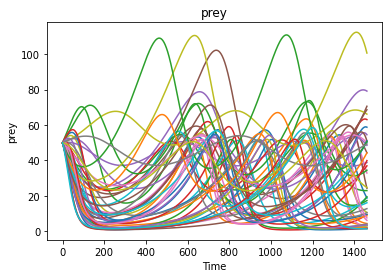

In [12]:
# Now making the figure works.
fig, axes = lines(results_py, outcome_py)

### placing this in a function to make it easier to use for the other models

In [13]:
#Based on this a function to make this easier
def fix_format_pls(dictionary, x, y):
    temp_array =  dictionary['prey']
    print(temp_array.shape)
    new_a = np.reshape(temp_array, (x, y))
    outcome = {'prey': new_a}
    return outcome

## Vensim

In [14]:
vensim_model = PysdModel(name= "Vensim", mdl_file=r'./model/PredPrey.mdl')
vensim_model.uncertainties = uncertainties
vensim_model.constants = constants
vensim_model.outcomes = outcomes


In [15]:
with MultiprocessingEvaluator(vensim_model, n_processes=processes) as evaluator:
    vensim_results, vensim_outcomes = evaluator.perform_experiments(scenarios=50, uncertainty_sampling=US)

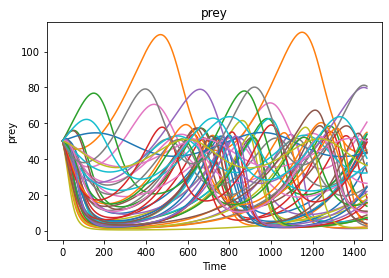

In [16]:
figure = lines(vensim_results, vensim_outcomes) #show lines, and end state density
plt.show() #show figure

## Excel

In [17]:
excel_model = ExcelModel(name="Excel", wd='./model/', model_file='../model/PredPrey.xlsx', default_sheet="Sheet1")


excel_model.uncertainties = uncertainties
excel_model.constants = constants2
excel_model.outcomes = outcomes

In [18]:
with SequentialEvaluator(excel_model) as evaluator:
    excel_results, excel_outcomes = evaluator.perform_experiments(scenarios=50, reporting_interval=1, uncertainty_sampling=US)

In [19]:
excel_outcomes2 = fix_format_pls(excel_outcomes, 50, 1461)

(50, 1, 1461)


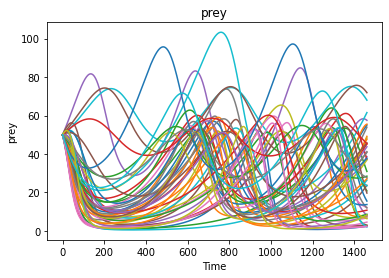

In [20]:
figure = lines(excel_results, excel_outcomes2) #show lines, and end state density
plt.show() #show figure

## Netlogo

In [22]:
netlogo_model = NetLogoModel(name="Netlogo", wd=r'./model/', model_file=r'../model/PredPrey.nlogo')
netlogo_model.run_length = 365
netlogo_model.replications = 1
    
netlogo_model.uncertainties = uncertainties
netlogo_model.constants = constants2
netlogo_model.outcomes = outcomes

In [23]:
with MultiprocessingEvaluator(netlogo_model, n_processes=processes) as evaluator:
    netlogo_results, netlogo_outcomes = evaluator.perform_experiments(scenarios=50)

(50, 1, 366)


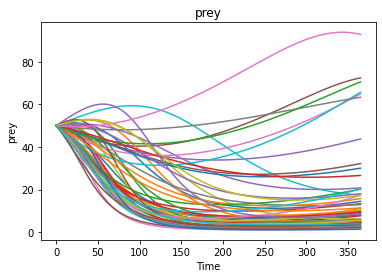

In [24]:
#This one has a different shape than the others so the function does not work. 
#Below is the same function with different shape.
netlogo_outcomes2 = fix_format_pls(netlogo_outcomes, 50, 366)

figure = lines(netlogo_results, netlogo_outcomes2) #show lines, and end state density
plt.show() #show figure

## Comparison

In [ ]:
# Make results easier to refer to
python_outcomes = outcomes_py
# vensim_outcomes already ok
excel_outcomes = excel_outcomes2
netlogo_outcomes = netlogo_outcomes2

